In [1]:
%reset -f

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import random
from scipy.stats import norm

import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
np.random.seed(42)
#

Inverse cumulative distribution function (inv_cdf) also known as the quantile function or the percent-point function (ppf)
##### Refer: https://stackoverflow.com/questions/20626994/how-to-calculate-the-inverse-of-the-normal-cumulative-distribution-function-in-p

In [3]:
#Compute the threshold and/or mean for univariate gaussian for the required mu_1
#Inverse cumulative distribution function (inv_cdf) also known as the quantile function or the percent-point function (ppf)
#Ref: https://stackoverflow.com/questions/20626994/how-to-calculate-the-inverse-of-the-normal-cumulative-distribution-function-in-p

threshold_sp86 = norm.ppf(0.86)                  # use this as threshold to get mean_sp=0.86

mean_for_mu80  = threshold_sp86 - norm.ppf(0.80) # sample_size = 50, mean for a univariate with sigma=1 to get a mean_sp=80 when using threshold_sp86 as threshold
mean_for_mu79  = threshold_sp86 - norm.ppf(0.792917961) # sample_size = 40
mean_for_mu78  = threshold_sp86 - norm.ppf(0.782540333) # sample_size = 30
mean_for_mu76  = threshold_sp86 - norm.ppf(0.76513167)  # sample_size = 20
mean_for_mu75  = threshold_sp86 - norm.ppf(0.750455488) # sample_size = 15
mean_for_mu72  = threshold_sp86 - norm.ppf(0.725835921) # sample_size = 10
mean_for_mu67  = threshold_sp86 - norm.ppf(0.67026334)  # sample_size = 5

#Print a summary table with sample_size, mu_prime and mean for the univariate function
summary_table        = pd.DataFrame(columns=["Samples", "mu1_prime", "Univairate Mean"])
summary_table.loc[1] = [50, 80, mean_for_mu80]
summary_table.loc[2] = [40, 79, mean_for_mu79]
summary_table.loc[3] = [30, 78, mean_for_mu78]
summary_table.loc[4] = [20, 76, mean_for_mu76]
summary_table.loc[5] = [15, 75, mean_for_mu75]
summary_table.loc[6] = [10, 72, mean_for_mu72]
summary_table.loc[7] = [5, 67, mean_for_mu67]

#Show the summary table
summary_table

,Samples,mu1_prime,Univairate Mean
1,50.0,80.0,0.238698
2,40.0,79.0,0.263732
3,30.0,78.0,0.299518
4,20.0,76.0,0.357412
5,15.0,75.0,0.404396
6,10.0,72.0,0.480052
7,5.0,67.0,0.639679


In [4]:
#Compute CUSUM for the observations in x (specificity in this case)
def compute_cusum(x, mu, k):
    #CUSUM for day0-2000: outcomes are detection delay and #FP, #TP, MTBFA, False alarm rate
    num_rows        = np.shape(x)[0]
    
    x_mean = np.zeros(num_rows,dtype=float)
    #S_hi : for positive changes --------------------------
    S_hi = np.zeros(num_rows,dtype=float)
    S_hi[0] = 0.0 # starts with 0
    #Increase in mean = x-mu-k ----------------------------
    mean_hi = np.zeros(num_rows,dtype=float)

    #Decrease in mean = mu-k-x----------------------------
    mean_lo = np.zeros(num_rows,dtype=float)
    #S_lo : for negative changes --------------------------
    S_lo = np.zeros(num_rows,dtype=float)
    S_lo[0] = 0.0 # starts with 0
    #CUSUM: Cumulative sum of x minus mu ------------------
    cusum = np.zeros(num_rows,dtype=float)
    cusum[0] = 0.0 # initialize with 0
    
    for i in range(0, num_rows):
        x_mean[i]  = x[i] - mu  #x - mean 
        mean_hi[i] = x[i] - mu - k
        S_hi[i]    = max(0, S_hi[i-1] + mean_hi[i])
        mean_lo[i] = mu - k - x[i]
        S_lo[i]    = max(0, S_lo[i-1] + mean_lo[i])
        cusum[i]   = cusum[i-1] + x_mean[i]

    x_mean  = np.round(x_mean,decimals=2)
    S_hi    = np.round(S_hi,decimals=2)
    mean_lo = np.round(mean_lo,decimals=2)
    S_lo    = np.round(S_lo,decimals=2)
    cusum   = np.round(cusum,decimals=2)

    # Construct the tabular CUSUM Chart  
    chart = np.array([])
    chart = np.column_stack((x.T, x_mean.T, mean_hi.T, S_hi.T, mean_lo.T, S_lo.T, cusum.T))
    np.round(chart, 2)

    #d = 2 *(np.log((1-0.01) / (0.0027)))
    #h = d * 0.5 # h= d*k where k=0.5
    #h = 4 # as per the NIST doc on CUSUM

    #l1 =  np.append(num_rows, data_tabular, axis = 1)
    #l1 = np.concatenate(num_rows.T, data_tabular.T)
    #chart = np.column_stack((num_rows.T, data_tabular.T))
    #chart

    np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
    #print("CUSUM Chart is:\n", np.round(chart,decimals=2))
    #x_mean

    df_out = pd.DataFrame(chart) 
    df_out.columns = ['X','x-mu','Increase in Mean', 'S_hi', 'Decrease-in-mean', 'S_lo', 'CUSUM']
    #filename = "file%d" %runs
    #df_out.to_csv(("CUSUM-out/file%d.csv" %runs), sep='\t')    
    #print(df.to_string())
    #print(chart)
    #Export datafrae to png
    #import dataframe_image as dfi
    #dfi.export(df,'CUSUM-out/CUSUM-run.png')
    
    return S_hi, S_lo, cusum

In [24]:
#Simulate the Sudden Drift scenario for 60 pre-change days and 60 post-change days with 50 samples per day
#Simulation Parameters
sample_size      = 5                     # samples per day
pre_change_days  = 60                     # pre- or post-change days
post_change_days = 60
total_days       = pre_change_days + post_change_days
threshold        = 1.08032

#Save the in-control and out-of-control specificities
sp_pre           = np.array([])
sp_post          = np.array([])
runs             = 0
#Gaussian Parameters
#mean1       = [0, 0]
#covariance1 = np.array([[1, 0], [0, 1]]) 
mu1, sigma1 = 0, 1 # mean and standard deviation

#Pick mu2 based on the sample size to maintain the constant displacement
if sample_size == 50:
  mu2 = mean_for_mu80
elif sample_size == 40:
  mu2 = mean_for_mu79
elif sample_size == 30:
  mu2 = mean_for_mu78
elif sample_size == 20:
  mu2 = mean_for_mu76
elif sample_size == 15:
  mu2 = mean_for_mu75
elif sample_size == 10:
  mu2 = mean_for_mu72
elif sample_size == 5:
  mu2 = mean_for_mu67
else:                  #default
  mu2 = mean_for_mu80  #default condition for sample_size = 50

sigma2 = 1 #standard deviation for the second gaussian

#CUSUM performance measures
FalsePos         =  np.array([])
TruePos          =  np.array([])
DelaytoDetect    =  np.array([])
FAR              =  np.array([])     #False Alarm Rate
inSTD_test_sp    =  np.array([])     #Standard deviation of test AUCs
outSTD_test_sp   =  np.array([]) 
in_mean_sp       =  np.array([])     #Mean Specificities
out_mean_sp      =  np.array([])
D                =  np.array([])     #Displacement
h_1000           =  np.array([]) 
k_1000           =  np.array([])
DetectionTimes   =  np.array([],dtype=int)
Dj               =  np.array([],dtype=int) #save the Dj which are binary values indicating detection MTBFA
Zj               =  np.array([],dtype=int) #save the Zj = min(Tj,pre-change-days)-MTBFA
zj               =  np.array([],dtype=int) # ADD - MLE of delays
cj               =  np.array([],dtype=int) # ADD - binary
AvgDD            = np.array([])      # Average Detection Delay

delta            = 1    #delta=normalized ref.value from table
control_limit    = 4
while (runs < 1000):
    days        = 0
    #start_in    = 0
    #end_in      = sample_size
    #start_out   = 0 
    #end_out     = sample_size
    specificity = np.array([])
    while (days < pre_change_days): #sample data from the first Gaussian until the number of pre-change days
        data_pre  = np.random.normal(mu1, sigma1, sample_size)
        #y0        = data_pre[:,1]
        #Compute the in-control specificity
        total       = len(data_pre)
        tn_pre      = 0
        fp_pre      = 0
        #print("threshold is:", threshold)
        for i in range(0, total):
            if (data_pre[i] > threshold):
                fp_pre += 1
            else:
                tn_pre += 1
        sp_in        = tn_pre / (tn_pre+fp_pre)
        specificity  = np.append(specificity, sp_in)
        sp_pre       = np.append(sp_pre, sp_in)    #Combine for histogram
        #print("pre-change specificity:",sp_in)
        days     += 1 
    while (days < total_days): #sample data each day from the second Gaussian until the number of post-change days
        data_post   = np.random.normal(mu2, sigma2, sample_size)
        #y1          = data_post[:,1]
        #Compute the out-of-control specificity
        total       = len(data_post)
        #threshold   = 1.14
        tn_post      = 0
        fp_post      = 0
        for i in range(0, total):
            if (data_post[i] > threshold):
                fp_post += 1
            else:
                tn_post += 1
        sp_o         = tn_post / (tn_post + fp_post)
        specificity  = np.append(specificity, sp_o)
        sp_post      = np.append(sp_post, sp_o)      #Combine for histogram
        #print("post-change specificity:",sp_o)
        
        days     += 1                               # increase the days until the total simulation days

    #Compute CUSUM to detect changepoint for the pre- and pos-change specificities
    num_rows        = np.shape(specificity)[0]
    in_control_sp   = specificity[:pre_change_days]
    out_control_sp  = specificity[pre_change_days:total_days]
    out_std_sp      = np.std(out_control_sp)
    in_std_sp       = np.std(in_control_sp)
    x               = np.array(specificity)

    mu     = np.mean(in_control_sp)
    mu_1   = np.mean(out_control_sp)
    std    = np.std(in_control_sp)
    std_1  = np.std(out_control_sp)
    displacement = (mu_1-mu)/std

    #print("in-control sp",mu)
    
    #h      = 0.102       # Upper/lower control limit to detect the changepoint H=0.102, 0.127 
    #k      = 0.03831     # Drift 0.01277 is the 1 sigma change, 0.0255 - one-sigma change, 0.03831 is 3-sigma change, 0.05108
    h      = in_std_sp * control_limit
    k      = (delta * in_std_sp)/2
   
    #Call compute CUSUM function with x (observatoins), in-control mean (mu) and k (drift or reference value)
    S_hi, S_lo, cusum = compute_cusum(x, mu, k)

    # False positives and Total alarms
    falsePos = 0
    alarms   = 0
    delay    = 0
    avddd    = 0   # this is the delay from the paper: td-ts (z_k-v) where v is the changepoint and z_k is the time of detection
    #MTBFA    = 0
    
    for i in range(0, pre_change_days):
        if ((S_hi[i] > h) or (S_lo[i] > h)):   
            #if (i<pre_change_days):
            falsePos += 1  #False Positives 
            #print("time false alarm",i)
            DetectionTimes= np.append(DetectionTimes, i+1)   #time at which a false positive is detected
            Dj = np.append(Dj, 1)
            Zj = np.append(Zj, min(i,pre_change_days))
            #print("detection times",DetectionTimes)
            #print("detection times size",DetectionTimes.size)
            break
        
    # If there is no false positive, Zj = pre_change_days, Dj = 0
    if falsePos == 0:
        Dj = np.append(Dj, 0)
        #DetectionTimes[runs] = pre_change_days
        Zj = np.append(Zj, pre_change_days)

    # Delay to detect the first changepoint
    #delay = 0
    for i in range(pre_change_days, total_days):
        if ((S_hi[i] > h) or (S_lo[i] > h)):
            alarms += 1           #True Positive: break after detecting one TP
            #print("alarm at : ", i)
            #delay  = i-1000+1    # ts is 100 because the change starts at day100
            avddd  = i-pre_change_days
            cj = np.append(cj, 1)
            zj = np.append(zj, min(avddd,total_days))
            break
    
    # If there is no true detection, zj = total simulation days, cj = 0
    if alarms == 0:
        cj = np.append(cj, 0)
        #DetectionTimes[runs] = pre_change_days
        zj = np.append(zj, total_days)    
    
    #Calculate MTBFA(Mean time time between False Alarms)
    #MTBFA = np.mean(DetectionTimes)
    #FlaseAlarmRate = 1/MTBFA
    
    FalsePos       = np.append(FalsePos, falsePos)
    TruePos        = np.append(TruePos, alarms)
    #DelaytoDetect = np.append(DelaytoDetect, delay)   # td-ts+1
    #FAR           = np.append(FAR, FlaseAlarmRate)
    #DetectionTimes= np.append(DetectionTimes, detectionTime)
    AvgDD          = np.append(AvgDD, avddd)   # ADD estimate from the paper
    outSTD_test_sp = np.append(outSTD_test_sp, out_std_sp)
    inSTD_test_sp  = np.append(inSTD_test_sp, in_std_sp)
    in_mean_sp     = np.append(in_mean_sp, mu)
    out_mean_sp    = np.append(out_mean_sp, mu_1)
    D              = np.append(D, displacement)
    h_1000         = np.append(h_1000, h)
    k_1000         = np.append(k_1000, k)
    #print(falsePos)    
    
        
    #Shuffle the patient list for the next simulation
    #random.shuffle(patients_in)
    #random.shuffle(patients_o)
    runs      += 1  # continue until end of simulation

In [20]:
print("--------------------------------")
print("Control Limit:\t", control_limit)
print("Reference Value:\t", delta)
print("Pre/Post Change Days:\t", pre_change_days)
print("Samples per day:\t", sample_size)
print("--------------------------------")
print("total number of False Positives:",np.sum(FalsePos))
print("Total True Negatives:",np.sum(TruePos))
print("Total Missed Detections:",runs-np.sum(TruePos))
print("Average Detection Delay:",np.mean(AvgDD))
print("Average Detection Delay NEW:",np.sum(zj)/np.sum(cj))
print("Standard deviation for ADD:",np.std(AvgDD))
print("Minimum Delay:",np.min(AvgDD))
print("Maximum Delay:",np.max(AvgDD))
MTBFA = np.mean(DetectionTimes)
MLP = np.sum(Dj)/np.sum(Zj)
MTBFA_new = 1/MLP
FlaseAlarmRate = 1/MTBFA
print("MTBFA:", MTBFA)
print("MTBFA new", MTBFA_new)
print("Flase Alarm Rate:", FlaseAlarmRate)    
print("Mean ref. Value:", np.mean(k_1000))    
print("Mean STD_0:\t", np.mean(inSTD_test_sp)) 
print("Mean STD_1:\t", np.mean(outSTD_test_sp))
print("Mean in-control sp:\t", np.mean(in_mean_sp))
print("Mean out-of-control sp:\t", np.mean(out_mean_sp))
#print("Displacement, d:\t",(mu_1-mu)/std)
print("Mean Displacement:\t", np.mean(D))

--------------------------------
Control Limit:	 4
Reference Value:	 1
Pre/Post Change Days:	 60
Samples per day:	 15
--------------------------------
total number of False Positives: 230.0
Total True Negatives: 1000.0
Total Missed Detections: 0.0
Average Detection Delay: 4.659
Average Detection Delay NEW: 4.659
Standard deviation for ADD: 4.01854687667072
Minimum Delay: 0.0
Maximum Delay: 37.0
MTBFA: 32.995652173913044
MTBFA new 232.86521739130436
Flase Alarm Rate: 0.030307023323230993
Mean ref. Value: 0.04405869535563904
Mean STD_0:	 0.08811739071127808
Mean STD_1:	 0.11008698064760011
Mean in-control sp:	 0.8600188888888889
Mean out-of-control sp:	 0.750051111111111
Mean Displacement:	 -1.2636763204508845


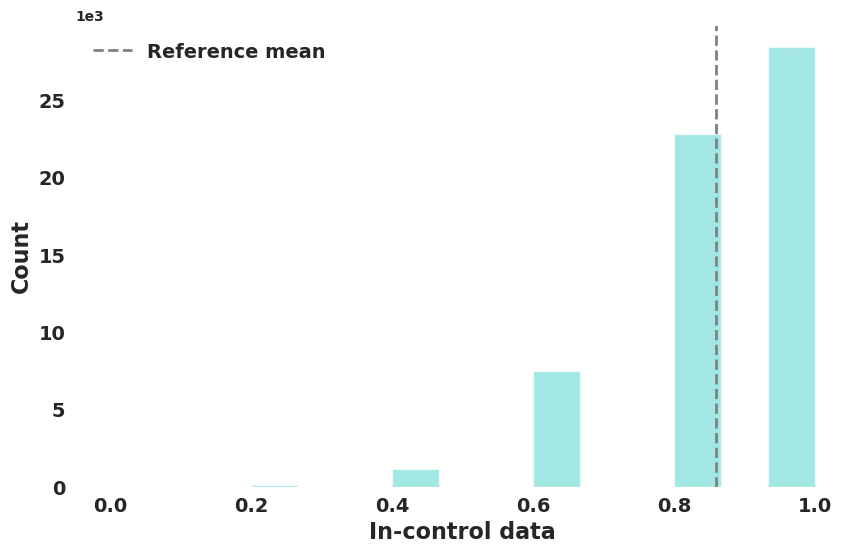

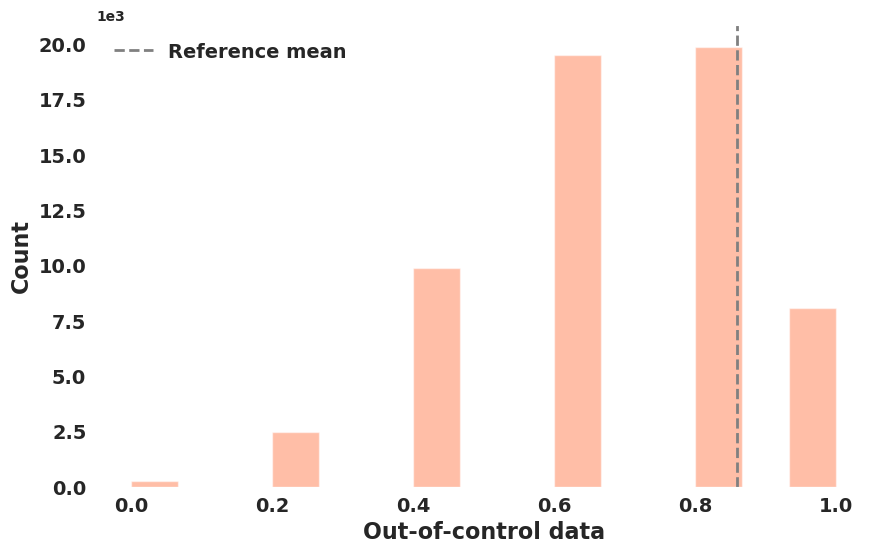

In [32]:
# PLOT THE HISTOGRAM OF Specificities - all the specificities for 1000 simulations * 100 days (vary samples per day)

#Display the histogram of in-control Sp
import matplotlib.pyplot as plt
from matplotlib import rcParams

fig, ax = plt.subplots(figsize=(10, 6))
rcParams['font.weight'] = 'bold'
count, bins, ignored = plt.hist(sp_pre, 15, color = "mediumturquoise", alpha=0.5)
#plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu)**2 / (2 * std**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
ax.axvline(x=0.86, color='grey', linestyle='--', label='Reference mean', linewidth=2.0) 
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel('In-control data', fontsize=16, fontweight='bold')
ax.set_ylabel('Count', fontsize=16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=14, frameon=False)
#plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
#plt.title('Histogram for in-control specificity')
plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
plt.show()

#Display the histogram of out-of-control Sp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
count, bins, ignored = plt.hist(sp_post, 15, color = "coral", alpha=0.5) #15 for 5 samples
#plt.plot(bins, 1/(std_1 * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu_1)**2 / (2 * std_1**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
ax.axvline(x=0.86, color='grey', linestyle='--', label='Reference mean', linewidth=2.0) 
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel('Out-of-control data', fontsize=16, fontweight='bold')
ax.set_ylabel('Count', fontsize=16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=14, frameon=False)
#plt.title('Histogram for out-of-control specificity')
plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
plt.show()

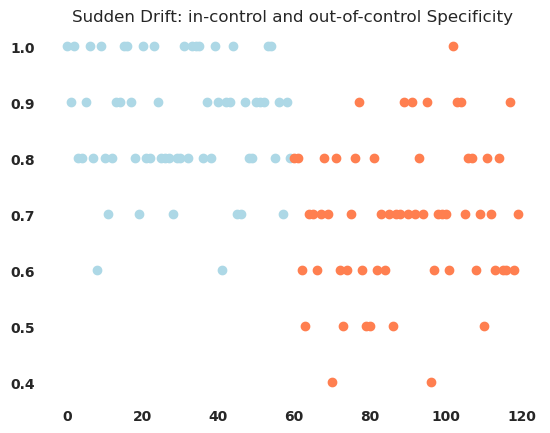

In [8]:
#Plot the specificity
#pre_change_days  = 60
#post_change_days = 60
total_days       = pre_change_days + post_change_days
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
y1 = np.arange(pre_change_days)
x1 = specificity[:pre_change_days]
plt.scatter(y1, x1, c='lightblue')
y2 = np.arange(pre_change_days, total_days, 1)
x2 = specificity[pre_change_days:total_days]  #prev
#x2 = specificity_medk10[:pre_change_days]
plt.scatter(y2, x2, c='coral')
#plt.hlines(y = mu, xmin=0, xmax=pre_change_days,color = 'lightblue', linestyle = '--')
#plt.hlines(y = mu1, xmin=pre_change_days, xmax=total_days,color = 'coral', linestyle = '--')
# single vline with specific ymin and ymax
#plt.vlines(x=pre_change_days, ymin=mu1, ymax=mu, colors='lightgrey', linestyle = '--')
#yline(0.86)
#plt.plot(test_AUC, 'go')


plt.title('Sudden Drift: in-control and out-of-control Specificity')
plt.show()

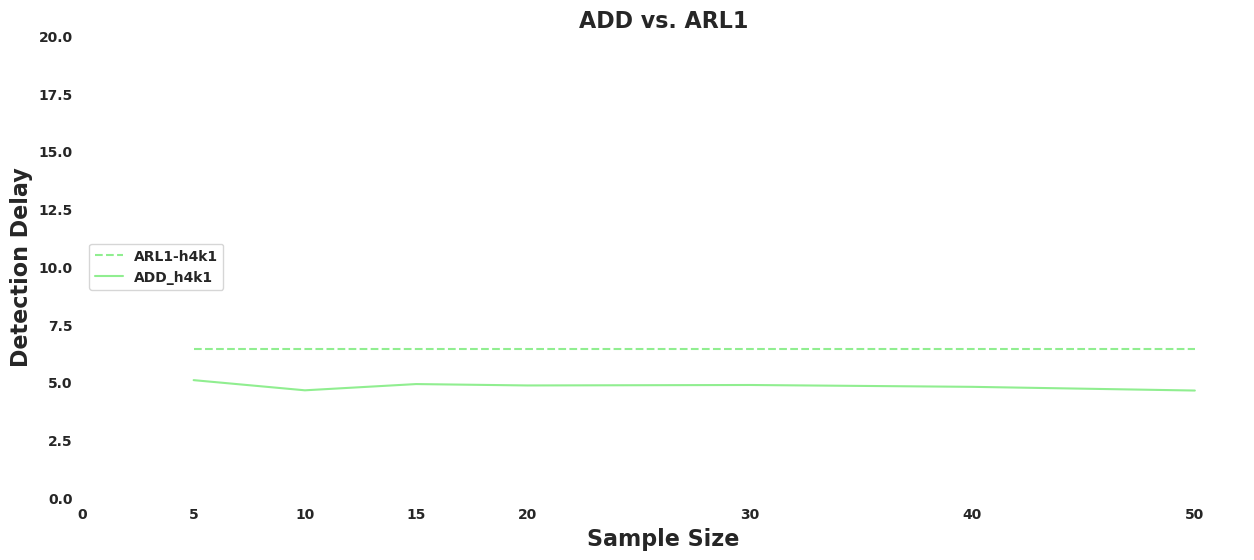

In [9]:
#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h4K2
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))
#fig = plt.figure(frameon=False)
#fig.set_size_inches(15,6)
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)

rcParams['font.weight'] = 'bold'
plt.rcParams['axes.facecolor'] = 'white'


#ARL1
h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
ADD_h4k1 = [5.09, 4.65, 4.92, 4.86, 4.88, 4.8, 4.64]
ADD_h5k1 = [6.52, 5.97, 6.26, 6.27, 5.88, 6.313, 6.48]
ADD_h4k2 = [10.48, 11.04, 11.3, 11.71, 11.70, 12.4, 12.94]
ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# ARL for the h-and-k
h4k1, = ax.plot(sample_size, h4k1, linestyle='dashed', c='lightgreen')
#h5k1, = ax.plot(sample_size, h5k1, linestyle='dashed', c='mediumblue')  #mediumseagreen
#h4k2, = ax.plot(sample_size, h4k2, linestyle='dashed', c='blueviolet')
#h5k2, = ax.plot(sample_size, h5k2, linestyle='dashed', c='orangered')

#ADDs for the h-and-k
ADD_h4k1, = ax.plot(sample_size, ADD_h4k1,  c='lightgreen')
#ADD_h5k1, = ax.plot(sample_size, ADD_h5k1,  c='mediumblue')  #mediumseagreen
#ADD_h4k2, = ax.plot(sample_size, ADD_h4k2,  c='blueviolet')
#ADD_h5k2, = ax.plot(sample_size, ADD_h5k2,  c='orangered')

#ax.set_title('2018-19 English Premier League Season')
#ax.set_ylabel('Log Points')
ax.set_ylim(0, 20)
#ax.set_xlabel('Week')
#ax.set_xlim(1, 38)
ax.legend(
    (h4k1, ADD_h4k1),
    ('ARL1-h4k1',  'ADD_h4k1'),
    loc='center left'
)
plt.xticks([0, 5, 10, 15, 20, 30, 40, 50])
plt.xlabel('Sample Size', fontsize=16, fontweight='bold')
plt.ylabel('Detection Delay', fontsize=16, fontweight='bold')
plt.title('ADD vs. ARL1', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

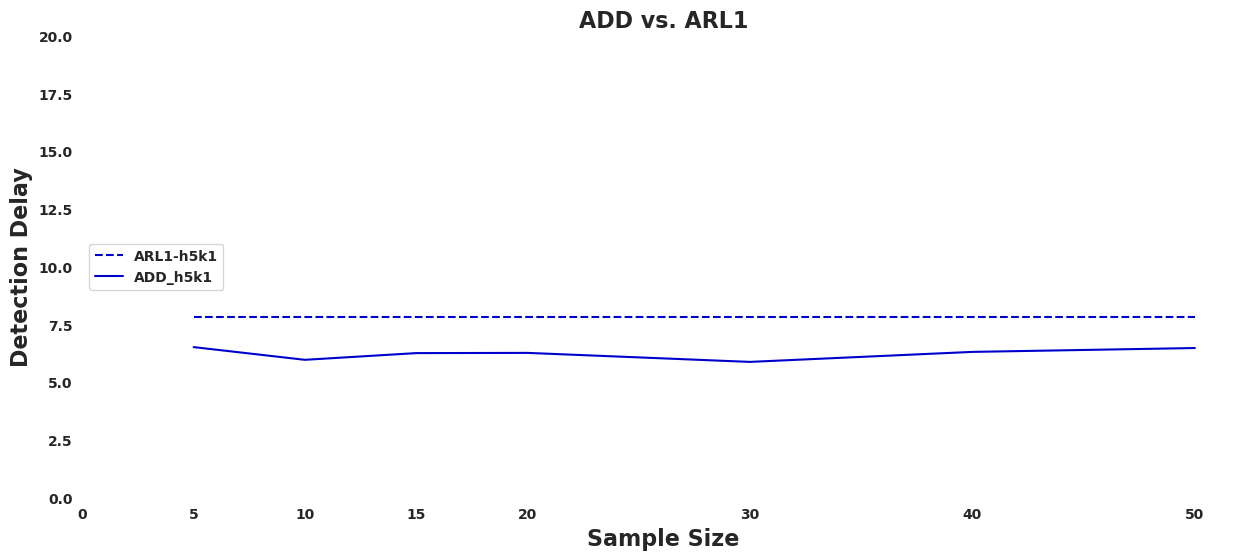

In [10]:
#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h5K1
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))
#fig = plt.figure(frameon=False)
#fig.set_size_inches(15,6)
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)

rcParams['font.weight'] = 'bold'
plt.rcParams['axes.facecolor'] = 'white'

#ARL1
h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
ADD_h4k1 = [5.09, 4.65, 4.92, 4.86, 4.88, 4.8, 4.64]
ADD_h5k1 = [6.52, 5.97, 6.26, 6.27, 5.88, 6.313, 6.48]
ADD_h4k2 = [10.48, 11.04, 11.3, 11.71, 11.70, 12.4, 12.94]
ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# ARL for the h-and-k
#h4k1, = ax.plot(sample_size, h4k1, linestyle='dashed', c='lightgreen')
h5k1, = ax.plot(sample_size, h5k1, linestyle='dashed', c='mediumblue')  #mediumseagreen
#h4k2, = ax.plot(sample_size, h4k2, linestyle='dashed', c='blueviolet')
#h5k2, = ax.plot(sample_size, h5k2, linestyle='dashed', c='orangered')

#ADDs for the h-and-k
#ADD_h4k1, = ax.plot(sample_size, ADD_h4k1,  c='lightgreen')
ADD_h5k1, = ax.plot(sample_size, ADD_h5k1,  c='mediumblue')  #mediumseagreen
#ADD_h4k2, = ax.plot(sample_size, ADD_h4k2,  c='blueviolet')
#ADD_h5k2, = ax.plot(sample_size, ADD_h5k2,  c='orangered')

#ax.set_title('2018-19 English Premier League Season')
#ax.set_ylabel('Log Points')
ax.set_ylim(0, 20)
#ax.set_xlabel('Week')
#ax.set_xlim(1, 38)
ax.legend(
    (h5k1, ADD_h5k1),
    ('ARL1-h5k1',  'ADD_h5k1'),
    loc='center left'
)
plt.xticks([0, 5, 10, 15, 20, 30, 40, 50])
plt.xlabel('Sample Size', fontsize=16, fontweight='bold')
plt.ylabel('Detection Delay', fontsize=16, fontweight='bold')
plt.title('ADD vs. ARL1', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

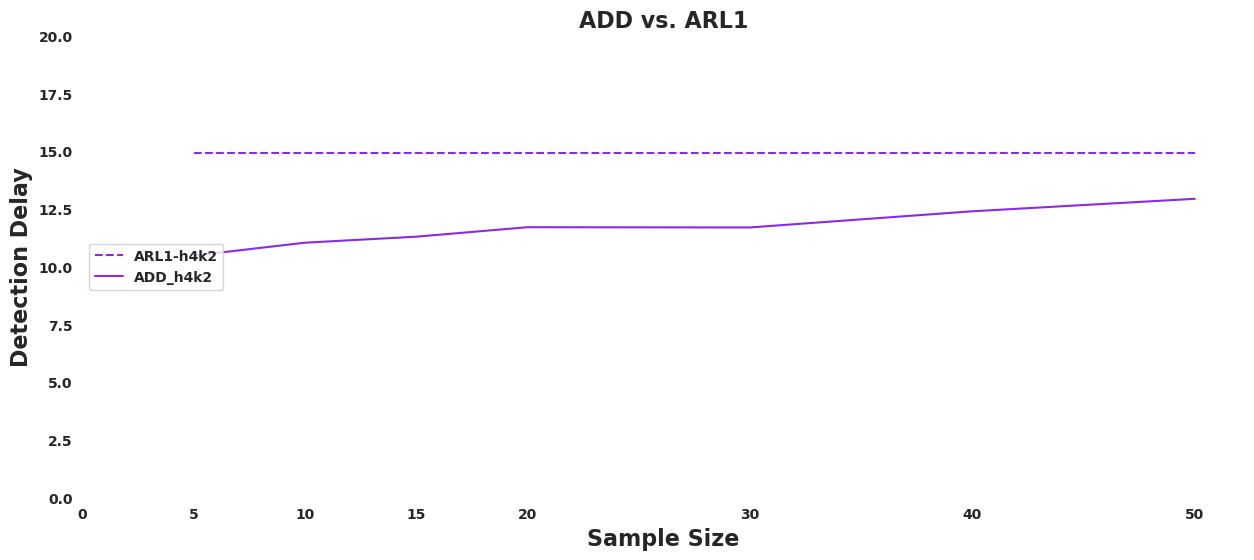

In [11]:
#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h4K2
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))
#fig = plt.figure(frameon=False)
#fig.set_size_inches(15,6)
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)

rcParams['font.weight'] = 'bold'
plt.rcParams['axes.facecolor'] = 'white'

#ARL1
#h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
#h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
#h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
ADD_h4k1 = [5.09, 4.65, 4.92, 4.86, 4.88, 4.8, 4.64]
ADD_h5k1 = [6.52, 5.97, 6.26, 6.27, 5.88, 6.313, 6.48]
ADD_h4k2 = [10.48, 11.04, 11.3, 11.71, 11.70, 12.4, 12.94]
ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# ARL for the h-and-k
#h4k1, = ax.plot(sample_size, h4k1, linestyle='dashed', c='lightgreen')
#h5k1, = ax.plot(sample_size, h5k1, linestyle='dashed', c='mediumblue')  #mediumseagreen
h4k2, = ax.plot(sample_size, h4k2, linestyle='dashed', c='blueviolet')
#h5k2, = ax.plot(sample_size, h5k2, linestyle='dashed', c='orangered')

#ADDs for the h-and-k
#ADD_h4k1, = ax.plot(sample_size, ADD_h4k1,  c='lightgreen')
#ADD_h5k1, = ax.plot(sample_size, ADD_h5k1,  c='mediumblue')  #mediumseagreen
ADD_h4k2, = ax.plot(sample_size, ADD_h4k2,  c='blueviolet')
#ADD_h5k2, = ax.plot(sample_size, ADD_h5k2,  c='orangered')

#ax.set_title('2018-19 English Premier League Season')
#ax.set_ylabel('Log Points')
ax.set_ylim(0, 20)
#ax.set_xlabel('Week')
#ax.set_xlim(1, 38)
ax.legend(
    (h4k2, ADD_h4k2),
    ('ARL1-h4k2', 'ADD_h4k2'),
    loc='center left'
)
plt.xticks([0, 5, 10, 15, 20, 30, 40, 50])
plt.xlabel('Sample Size', fontsize=16, fontweight='bold')
plt.ylabel('Detection Delay', fontsize=16, fontweight='bold')
plt.title('ADD vs. ARL1', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

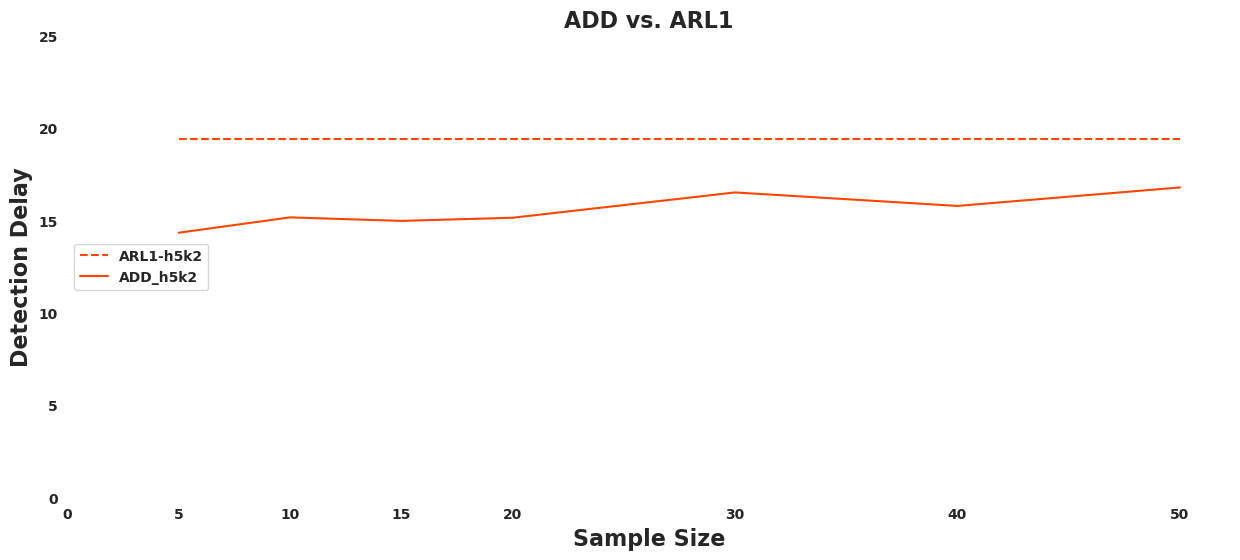

In [12]:
#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h5K2
#------------------------------------------------------

fig, ax = plt.subplots(figsize=(15, 6))
#fig = plt.figure(frameon=False)
#fig.set_size_inches(15,6)
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)

rcParams['font.weight'] = 'bold'
plt.rcParams['axes.facecolor'] = 'white'

#ARL1
h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
ADD_h4k1 = [5.09, 4.65, 4.92, 4.86, 4.88, 4.8, 4.64]
ADD_h5k1 = [6.52, 5.97, 6.26, 6.27, 5.88, 6.313, 6.48]
ADD_h4k2 = [10.48, 11.04, 11.3, 11.71, 11.70, 12.4, 12.94]
ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# ARL for the h-and-k
#h4k1, = ax.plot(sample_size, h4k1, linestyle='dashed', c='lightgreen')
#h5k1, = ax.plot(sample_size, h5k1, linestyle='dashed', c='mediumblue')  #mediumseagreen
#h4k2, = ax.plot(sample_size, h4k2, linestyle='dashed', c='blueviolet')
h5k2, = ax.plot(sample_size, h5k2, linestyle='dashed', c='orangered')

#ADDs for the h-and-k
#ADD_h4k1, = ax.plot(sample_size, ADD_h4k1,  c='lightgreen')
#ADD_h5k1, = ax.plot(sample_size, ADD_h5k1,  c='mediumblue')  #mediumseagreen
#ADD_h4k2, = ax.plot(sample_size, ADD_h4k2,  c='blueviolet')
ADD_h5k2, = ax.plot(sample_size, ADD_h5k2,  c='orangered')

#ax.set_title('2018-19 English Premier League Season')
#ax.set_ylabel('Log Points')
ax.set_ylim(0, 25)
#ax.set_xlabel('Week')
#ax.set_xlim(1, 38)
ax.legend(
    (h5k2, ADD_h5k2),
    ('ARL1-h5k2', 'ADD_h5k2'),
    loc='center left'
)
plt.xticks([0, 5, 10, 15, 20, 30, 40, 50])
plt.xlabel('Sample Size', fontsize=16, fontweight='bold')
plt.ylabel('Detection Delay', fontsize=16, fontweight='bold')
plt.title('ADD vs. ARL1', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

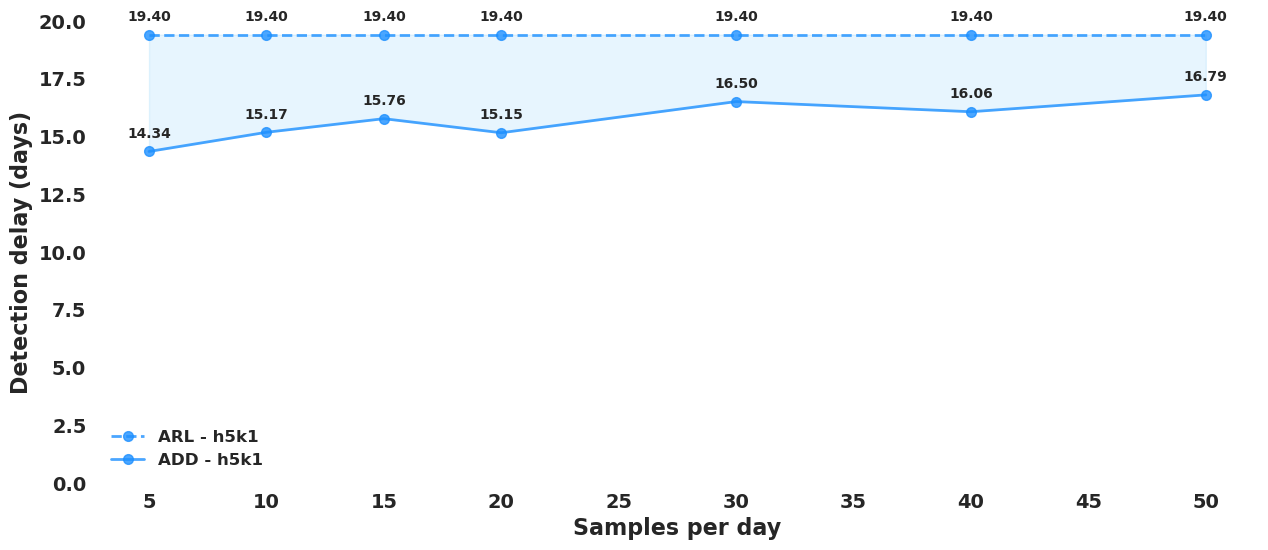

In [40]:
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h5k1
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))

sample_size =[5, 10, 15, 20, 30, 40, 50]
h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]
ADD_h5k2 = [14.34, 15.17, 15.76, 15.15, 16.5, 16.06, 16.79]

# 3. Plot data including options
plt.plot(sample_size, h5k2,
    linewidth=2,
    label='ARL - h5k1',
    linestyle='--',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

# 3. Plot data including options
plt.plot(sample_size, ADD_h5k2,
    linewidth=2,
    label='ADD - h5k1',
    linestyle='-',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

for x,y in zip(sample_size,h5k2):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(sample_size,ADD_h5k2):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# 4. Add plot details

plt.xlabel('Samples per day', fontsize=16, fontweight='bold')
plt.ylabel('Detection delay (days)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, frameon=False)

plt.xticks([0, 5, 10, 15, 20, 25,30,35, 40, 45,50])
#plt.grid(True)
ax.set_ylim(0, 20)
ax.fill_between(sample_size, h5k2, ADD_h5k2,color='lightskyblue',alpha=0.2)
#ax3.set_title('fill between y1 and y2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# 5. Show the plot
plt.show()

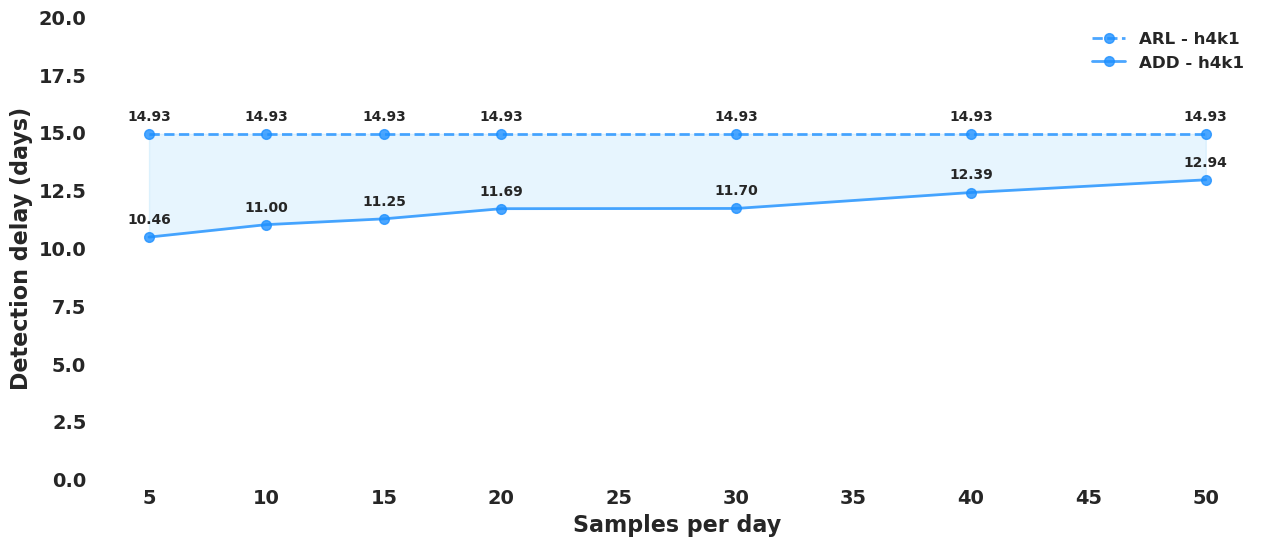

In [41]:

#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h5k1
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))

#ARL1
#h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
#h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
#h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
#ADD_h4k1 = [5.09, 4.65, 4.92, 4.86, 4.88, 4.8, 4.64]
#ADD_h5k1 = [6.52, 5.97, 6.26, 6.27, 5.88, 6.313, 6.48]
ADD_h4k2 = [10.46, 11.0, 11.25, 11.69, 11.70, 12.39, 12.94]
#ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# 3. Plot data including options
plt.plot(sample_size, h4k2,
    linewidth=2,
    label='ARL - h4k1',
    linestyle='--',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

# 3. Plot data including options
plt.plot(sample_size, ADD_h4k2,
    linewidth=2,
    label='ADD - h4k1',
    linestyle='-',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

for x,y in zip(sample_size,h4k2):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(sample_size,ADD_h4k2):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# 4. Add plot details

plt.xlabel('Samples per day', fontsize=16, fontweight='bold')
plt.ylabel('Detection delay (days)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, frameon=False)

plt.xticks([0, 5, 10, 15, 20, 25,30,35, 40, 45,50])
#plt.grid(True)
ax.set_ylim(0, 20)
ax.fill_between(sample_size, h4k2, ADD_h4k2,color='lightskyblue',alpha=0.2)
#ax3.set_title('fill between y1 and y2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# 5. Show the plot
plt.show()

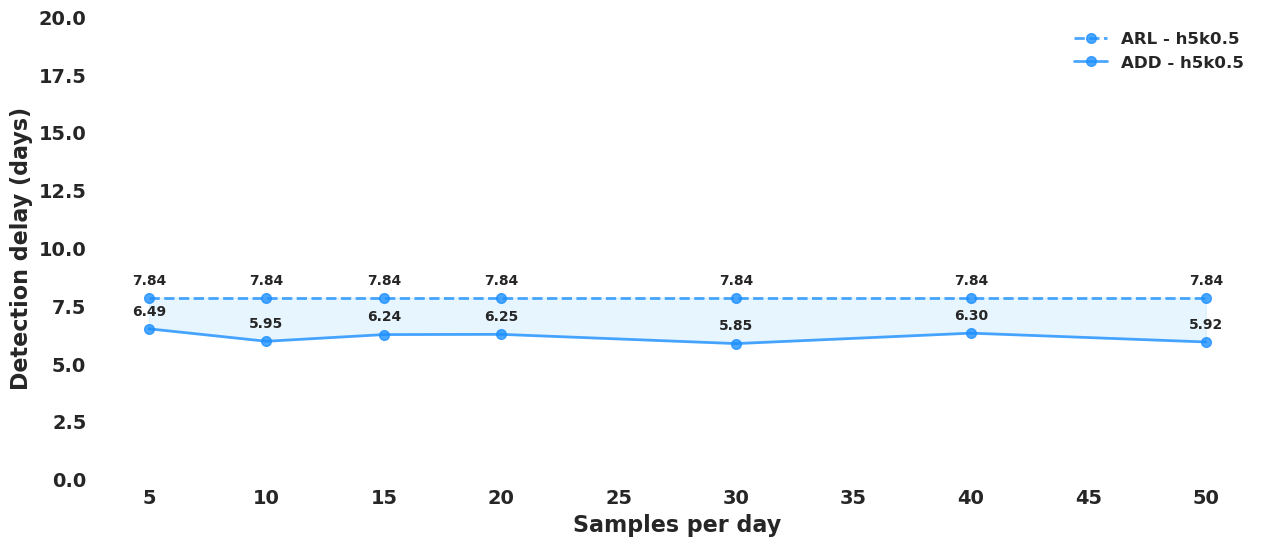

In [42]:
#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h5k0.5
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))

#ARL1
#h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
#h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
#h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
#ADD_h4k1 = [5.09, 4.65, 4.92, 4.86, 4.88, 4.8, 4.64]
ADD_h5k1 = [6.49, 5.95, 6.24, 6.25, 5.85, 6.302, 5.92]
#ADD_h4k2 = [10.48, 11.04, 11.3, 11.71, 11.70, 12.4, 12.94]
#ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# 3. Plot data including options
plt.plot(sample_size, h5k1,
    linewidth=2,
    label='ARL - h5k0.5',
    linestyle='--',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

# 3. Plot data including options
plt.plot(sample_size, ADD_h5k1,
    linewidth=2,
    label='ADD - h5k0.5',
    linestyle='-',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

for x,y in zip(sample_size,h5k1):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(sample_size,ADD_h5k1):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# 4. Add plot details

plt.xlabel('Samples per day', fontsize=16, fontweight='bold')
plt.ylabel('Detection delay (days)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, frameon=False)

plt.xticks([0, 5, 10, 15, 20, 25,30,35, 40, 45,50])
#plt.grid(True)
ax.set_ylim(0, 20)
ax.fill_between(sample_size, h5k1, ADD_h5k1,color='lightskyblue',alpha=0.2)
#ax3.set_title('fill between y1 and y2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# 5. Show the plot
plt.show()

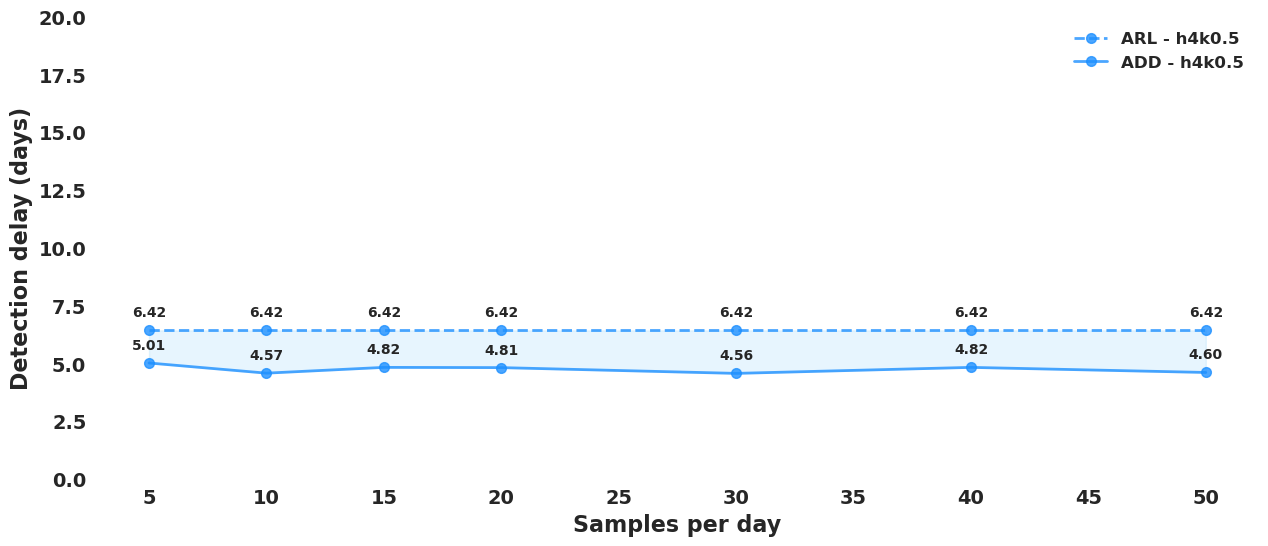

In [43]:
#------------------------------------------------------
# PLOT CUSUM Robustness Test ADD vs ARL1  --- for h4k0.5
#------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))

#ARL1
h4k1 = [6.42, 6.42, 6.42, 6.42, 6.42, 6.42, 6.42]
#h5k1 = [7.84, 7.84, 7.84, 7.84, 7.84, 7.84, 7.84,]
#h4k2 = [14.93, 14.93, 14.93, 14.93, 14.93, 14.93, 14.93]
#h5k2 =  [19.4, 19.4, 19.4, 19.4, 19.4, 19.4, 19.4]

#ADD
ADD_h4k1 = [5.01, 4.57, 4.82, 4.81, 4.56, 4.82, 4.60]
#ADD_h5k1 = [6.52, 5.97, 6.26, 6.27, 5.88, 6.313, 6.48]
#ADD_h4k2 = [10.48, 11.04, 11.3, 11.71, 11.70, 12.4, 12.94]
#ADD_h5k2 = [14.34, 15.17, 14.98, 15.15, 16.52, 15.79, 16.79]

sample_size =[5, 10, 15, 20, 30, 40, 50]

# 3. Plot data including options
plt.plot(sample_size, h4k1,
    linewidth=2,
    label='ARL - h4k0.5',
    linestyle='--',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

# 3. Plot data including options
plt.plot(sample_size, ADD_h4k1,
    linewidth=2,
    label='ADD - h4k0.5',
    linestyle='-',
    color='dodgerblue',
    alpha=0.8,
    marker='o',
    markersize=7,
    markerfacecolor='dodgerblue')

for x,y in zip(sample_size,h4k1):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(sample_size,ADD_h4k1):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# 4. Add plot details

plt.xlabel('Samples per day', fontsize=16, fontweight='bold')
plt.ylabel('Detection delay (days)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, frameon=False)

plt.xticks([0, 5, 10, 15, 20, 25,30,35, 40, 45,50])
#plt.grid(True)
ax.set_ylim(0, 20)
ax.fill_between(sample_size, h4k1, ADD_h4k1,color='lightskyblue',alpha=0.2)
#ax3.set_title('fill between y1 and y2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# 5. Show the plot
plt.show()